# Challenge: Optimization on Other Datasets

## Download data from `yfinance`

In [1]:
import yfinance as yf

ticker = 'AAPL'
df = yf.download(ticker)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087581,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600
...,...,...,...,...,...,...
2023-05-05,170.979996,174.300003,170.759995,173.570007,173.570007,113316400
2023-05-08,172.479996,173.850006,172.110001,173.500000,173.500000,55962800
2023-05-09,173.050003,173.539993,171.600006,171.770004,171.770004,45326900


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [2]:
df = df.loc['2020-01-01':].copy()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314896,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200
...,...,...,...,...,...,...
2023-05-05,170.979996,174.300003,170.759995,173.570007,173.570007,113316400
2023-05-08,172.479996,173.850006,172.110001,173.500000,173.500000,55962800
2023-05-09,173.050003,173.539993,171.600006,171.770004,171.770004,45326900


### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [3]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400,-0.981753
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800,0.790538
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314896,118387200,-0.472537
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000,1.583145
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200,2.079920
...,...,...,...,...,...,...,...
2023-05-05,170.979996,174.300003,170.759995,173.570007,173.570007,113316400,-0.040350
2023-05-08,172.479996,173.850006,172.110001,173.500000,173.500000,55962800,-1.007158
2023-05-09,173.050003,173.539993,171.600006,171.770004,171.770004,45326900,1.031340


#### Remove rows with any missing data

In [4]:
df = df.dropna().copy()
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400,-0.981753
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800,0.790538
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314896,118387200,-0.472537
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000,1.583145
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200,2.079920
...,...,...,...,...,...,...,...
2023-05-04,164.889999,167.039993,164.309998,165.789993,165.789993,81235400,4.482349
2023-05-05,170.979996,174.300003,170.759995,173.570007,173.570007,113316400,-0.040350
2023-05-08,172.479996,173.850006,172.110001,173.500000,173.500000,55962800,-1.007158


## Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
model = RandomForestRegressor(max_depth=20, random_state=42)

In [7]:
y = df.change_tomorrow
X = df.drop(columns='change_tomorrow')

In [8]:
model.fit(X, y)

RandomForestRegressor(max_depth=20, random_state=42)

In [9]:
model.score(X, y)

0.8026124420516394

## Parametrize & optimize the investment strategy

### Create Strategy class

In [10]:
from backtesting import Strategy

/Users/sota/miniforge3/envs/backtesting/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [11]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create `Backtest` class

In [12]:
from backtesting import Backtest

In [13]:
bt = Backtest(
    X, Regression, cash=10000,
    commission=.002, exclusive_orders=True
)

### Optimize backtesting with multiple combinations

In [15]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

### Which are the best values for the parameters?

In [16]:
import numpy as np

In [19]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,123,nan
1,nan,nan,nan,nan,nan,73,nan,105,nan,nan,nan
2,123,nan,186,nan,360,nan,74,nan,nan,nan,nan
3,nan,-48,nan,68,nan,nan,nan,nan,132,nan,nan
4,nan,nan,-67,115,nan,nan,nan,nan,nan,nan,155
5,-82,-77,nan,nan,nan,-20,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,172,nan
7,-100,nan,nan,nan,nan,nan,nan,-100,nan,-100,nan
8,nan,nan,nan,0,nan,0,0,nan,nan,nan,nan


### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

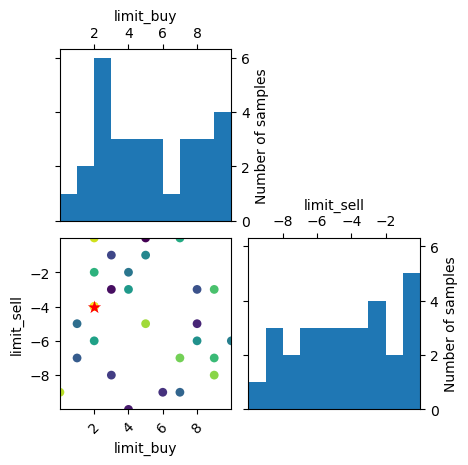

In [20]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

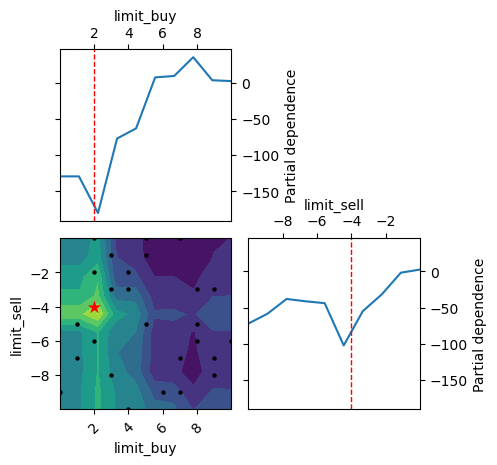

In [21]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## Continue with the tutorials on the following chapter

[LinkedIn Course Chapter]()